# Is the snow bias over Himalaya present in all experiments: historical, AMIP and land-hist?
- historical: all coupled
- AMIP: LMDZ/Orchidée with prescribed SST
- land-hist: Orchidée with prescribed atmosphere and SST

-> climatology on the reference period 1981-2014 (SnowCMIP6 paper) compared to the Rutger University data set: Weekly Snow Cover Extent Dataset Access (https://climate.rutgers.edu/snowcover/docs.php?target=datareq)  
More infos: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

## Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 166 GB / percent used: 33.8 %


## Load model data

In [3]:
# Define period
period = slice('1981','2014')

In the next cells the `chunks={'time': 120}` allows not to load full data set but take it by chunks of 10 years. This allows to parallelize the computation and/or make fit into the memory (see **xarray/dask**: http://xarray.pydata.org/en/stable/dask.html)

In [4]:
# Get historical snc
snc_historical = u.get_data_IPSL_CM6A_LR('snc', experiment='historical', time=period, chunks={'time': 120})
snc_historical

<xarray.DataArray 'snc' (realization: 32, time: 408, lat: 143, lon: 144)>
dask.array<concatenate, shape=(32, 408, 143, 144), dtype=float32, chunksize=(1, 120, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' ... 'r32i1p1f1'
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [5]:
# Get AMIP snc
snc_amip = u.get_data_IPSL_CM6A_LR('snc', experiment='amip', time=period, chunks={'time': 120})
snc_amip

<xarray.DataArray 'snc' (realization: 21, time: 408, lat: 143, lon: 144)>
dask.array<concatenate, shape=(21, 408, 143, 144), dtype=float32, chunksize=(1, 108, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' ... 'r21i1p1f1'
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [6]:
# Get land-hist snc
snc_land_hist = u.get_data_IPSL_CM6A_LR('snc', experiment='land-hist', time=period, chunks={'time': 120})
snc_land_hist

<xarray.DataArray 'snc' (realization: 1, time: 408, lat: 143, lon: 144)>
dask.array<broadcast_to, shape=(1, 408, 143, 144), dtype=float32, chunksize=(1, 120, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 -90.0 -88.73239 -87.46479 ... 88.73239 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * realization  (realization) object 'r1i1p1f1'
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

## Load Rutger University data set

In [7]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
ds_rutger

<xarray.Dataset>
Dimensions:               (cols: 88, rows: 88, time: 1774)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-05 ... 2014-12-29
    snow_cover_threshold  float32 ...
    latitude              (rows, cols) float64 ...
    longitude             (rows, cols) float64 ...
Dimensions without coordinates: cols, rows
Data variables:
    coord_system          |S1 ...
    land                  (rows, cols) float32 ...
    area                  (rows, cols) float32 ...
    snow_cover_extent     (time, rows, cols) float32 ...
Attributes:
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        nhsce_v01r01_19661004_20191202.nc
    naming_authority:          gov.noaa.ncdc
    metadata_link:             https://doi.org/10.7289/V5N014G9
    title:                     Climate Data Record (CDR) of Northern Hemisphe...
    product_version:           v01r01
    summary:                   The data record for the NH SCE CDR spans from ...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW C...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    platform:                  ESSA, NOAA POES, SMS, DMSP, GOES, TIROS, METEO...
    sensor:                    VIDEO CAMERA, VISSR, VAS, VHRR, AVHRR, VISSR-G...
    cdm_data_type:             Grid
    cdr_program:               NOAA Climate Data Record Program for satellites
    cdr_variable:              snow_cover_extent
    source:                    NOAA NH Weekly SCE, NIC NH IMS SCE
    date_created:              2019-12-03T03:11:23Z
    institution:               Global Snow Lab, Center for Environmental Pred...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    geospatial_lat_min:        0.0
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    spatial_resolution:        Minimum cell area 10676.8 km^2, maximum cell a...
    time_coverage_start:       1966-10-04
    time_coverage_end:         2019-12-02
    license:                   No restrictions on access or use

### Get the snc variable, keep only land data, convert to % and resample by months
Resampling with xarray: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html  
**Offset aliases**: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases  
Here we use: **MS**	month start frequency

In [8]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    snc_rutger = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
snc_rutger.attrs['units'] = '%'

# Rename lon and lat for the regrid
snc_rutger = snc_rutger.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
snc_rutger = snc_rutger.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
snc_rutger

/home/mlalande/miniconda3/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/home/mlalande/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (time: 408, rows: 88, cols: 88)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-01 ... 2014-12-01
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    long_name:      NOAA/NCDC Climate Data Record of snow cover extent
    standard_name:  surface_snow_binary_mask
    grid_mapping:   coord_system
    valid_range:    [0 1]
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered
    units:          %

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/)
Value of cells in the new grid that are outside the old grid's domain #15 (https://github.com/JiaweiZhuang/xESMF/issues/15)

In [9]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder = xe.Regridder(snc_rutger, snc_historical, 'bilinear', periodic=False)
regridder = add_matrix_NaNs(regridder)
print(regridder)

# Regrid the data
snc_rutger_regrid = regridder(snc_rutger)

Overwrite existing file: bilinear_88x88_143x144.nc 
 You can set reuse_weights=True to save computing time.


/home/mlalande/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

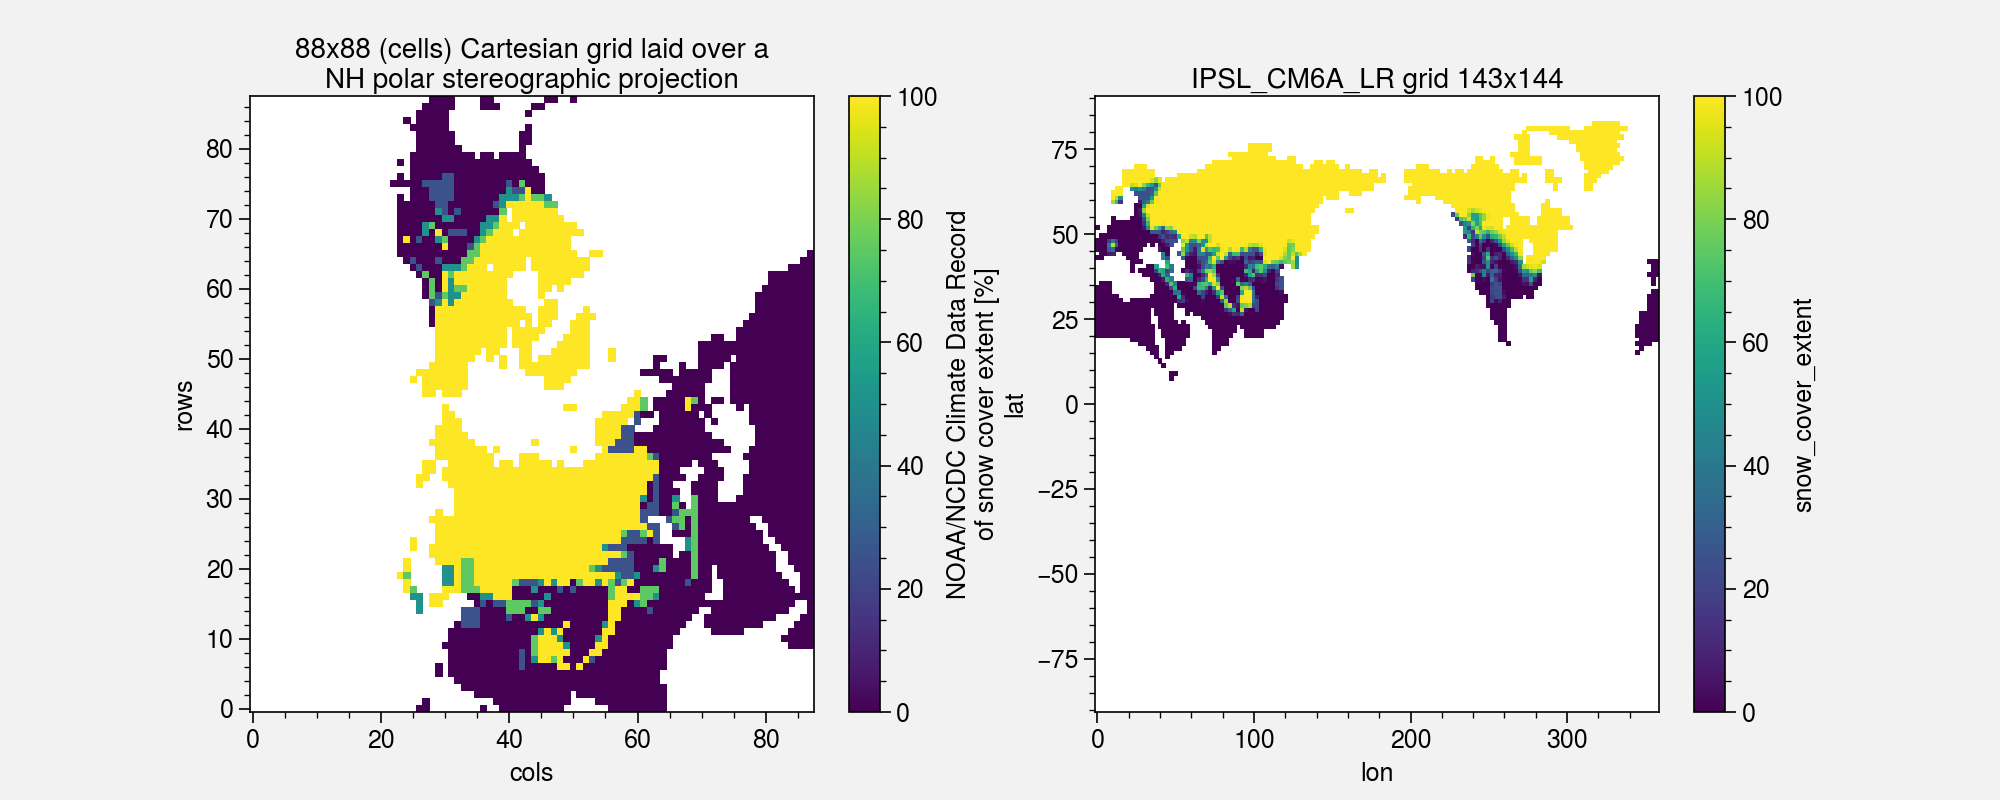

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(121)
snc_rutger[0].plot()
plt.title('88x88 (cells) Cartesian grid laid over a\nNH polar stereographic projection')
plt.subplot(122)
snc_rutger_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

## Fisrt guess plot 
Time: January 1981 / Realization: r1i1p1

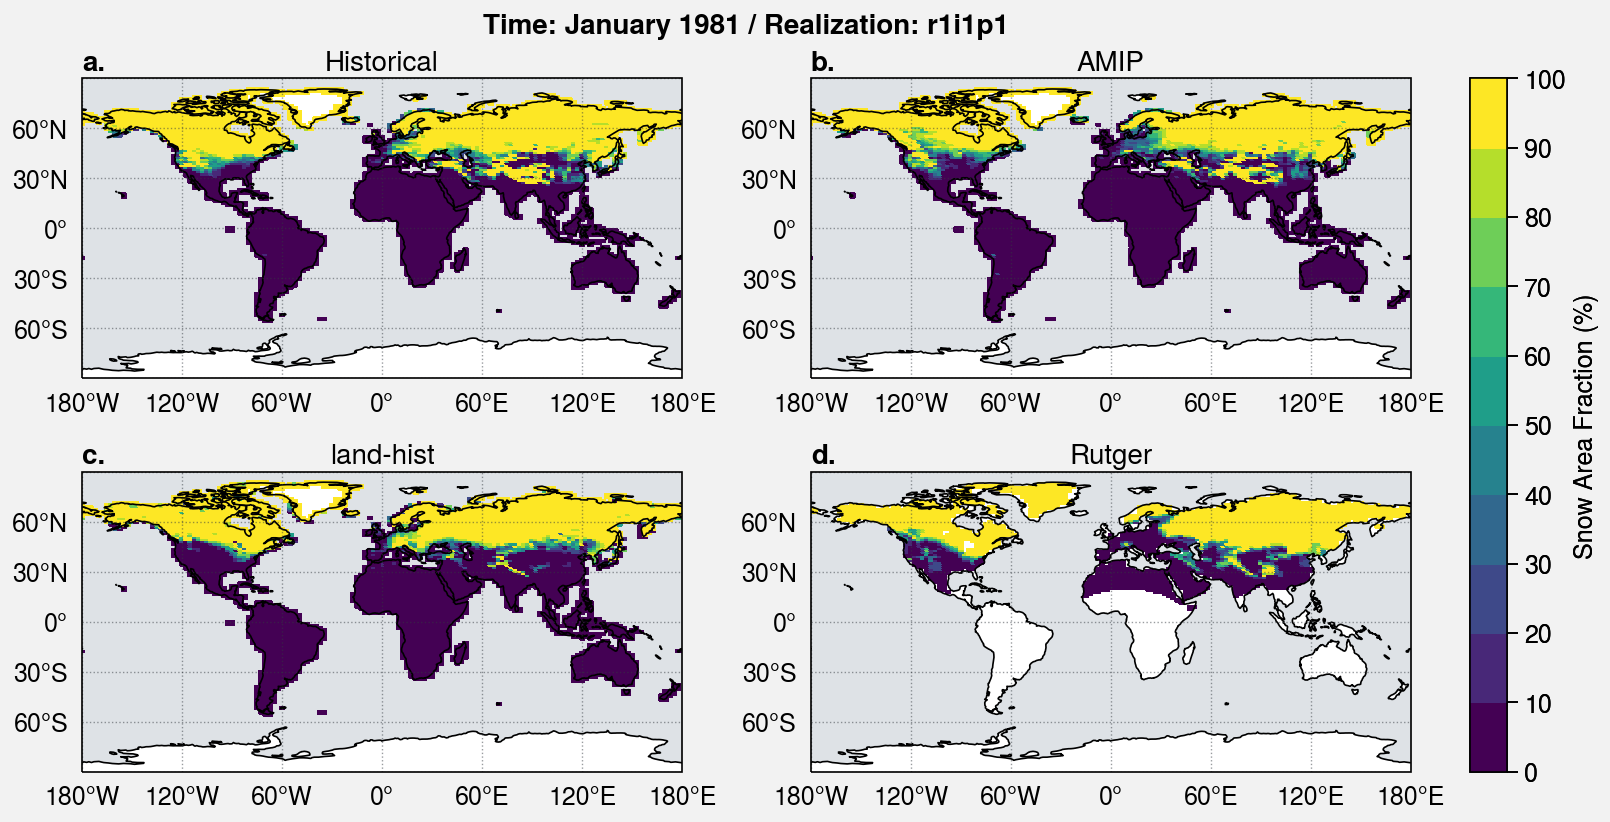

In [11]:
# First guess plot comparison
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

cmap='viridis'
levels=plot.arange(0,100,10)

m = axs[0].pcolormesh(snc_historical[0,0], cmap=cmap, levels=levels)
axs[0].format(title='Historical')
axs[1].pcolormesh(snc_amip[0,0], cmap=cmap, levels=levels)
axs[1].format(title='AMIP')
axs[2].pcolormesh(snc_land_hist[0,0], cmap=cmap, levels=levels)
axs[2].format(title='land-hist')
axs[3].pcolormesh(snc_rutger_regrid[0], cmap=cmap, levels=levels)
axs[3].format(title='Rutger')

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3',
    suptitle="Time: January 1981 / Realization: r1i1p1",
    lonlines=60, latlines=30, abc=True, abcstyle='a.'
)

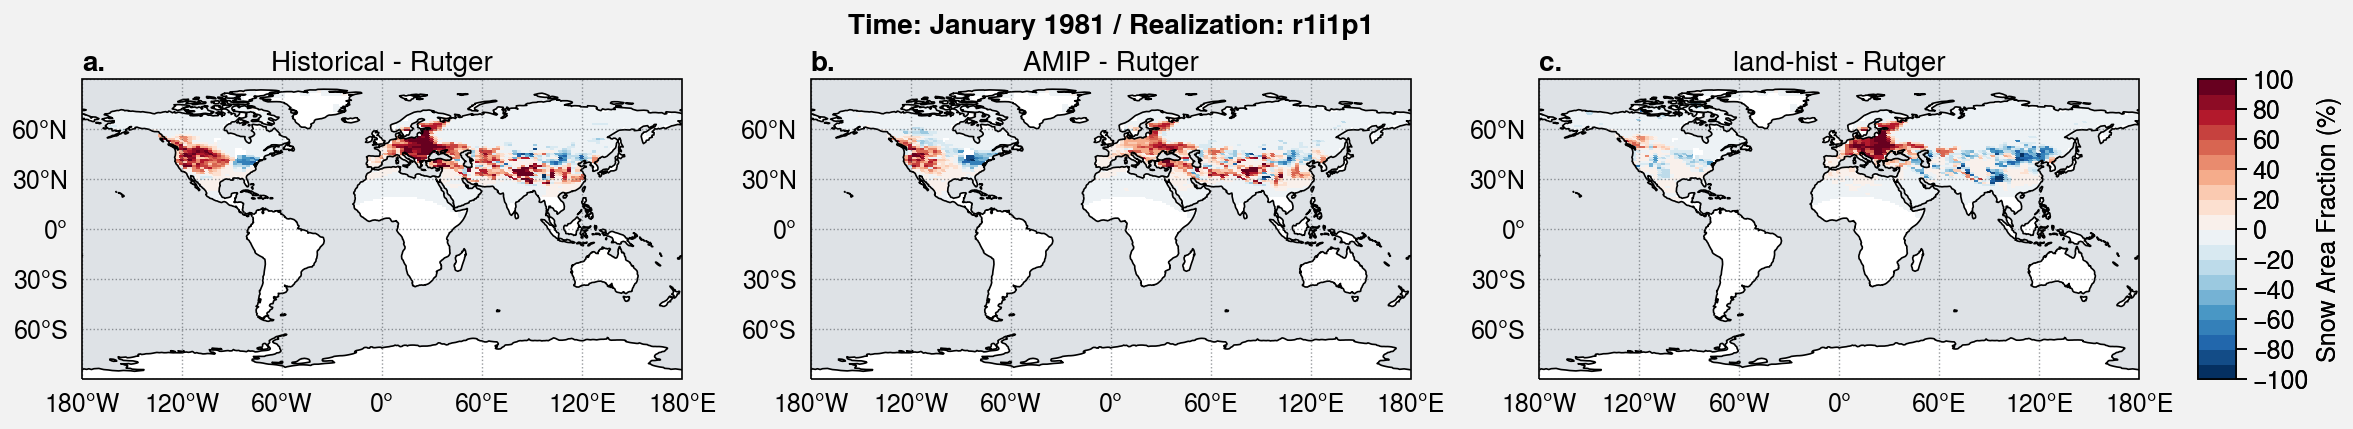

In [12]:
# Differences from Rutger
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, share=3, axwidth=3)

cmap='RdBu_r'
levels=plot.arange(-100,100,10)

m = axs[0].pcolormesh(snc_historical[0,0]-snc_rutger_regrid[0], cmap=cmap, levels=levels)
axs[0].format(title='Historical - Rutger')
axs[1].pcolormesh(snc_amip[0,0]-snc_rutger_regrid[0], cmap=cmap, levels=levels)
axs[1].format(title='AMIP - Rutger')
axs[2].pcolormesh(snc_land_hist[0,0]-snc_rutger_regrid[0], cmap=cmap, levels=levels)
axs[2].format(title='land-hist - Rutger')

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3',
    suptitle="Time: January 1981 / Realization: r1i1p1",
    lonlines=60, latlines=30, abc=True, abcstyle='a.'
)

-> **land-hist** seems to **less overestimate** the snow cover over the Himalya and Rocky Mountains

## Climatology over the ensemble mean
Is land-hist relevent with only one realization?

In [13]:
snc_historical_clim = u.clim(snc_historical.mean('realization', keep_attrs=True))
snc_historical_clim.load()

snc_amip_clim = u.clim(snc_amip.mean('realization', keep_attrs=True))
snc_amip_clim.load()

snc_land_hist_clim = u.clim(snc_land_hist.mean('realization', keep_attrs=True))
snc_land_hist_clim.load()

snc_rutger_regrid_clim = u.clim(snc_rutger_regrid)
snc_rutger_regrid_clim.load()

/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/mlalande/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide


<xarray.DataArray (lat: 143, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    snow_cover_threshold  float32 0.42
  * lon                   (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                   (lat) float32 -90.0 -88.73239 ... 88.73239 90.0
Attributes:
    regrid_method:  bilinear

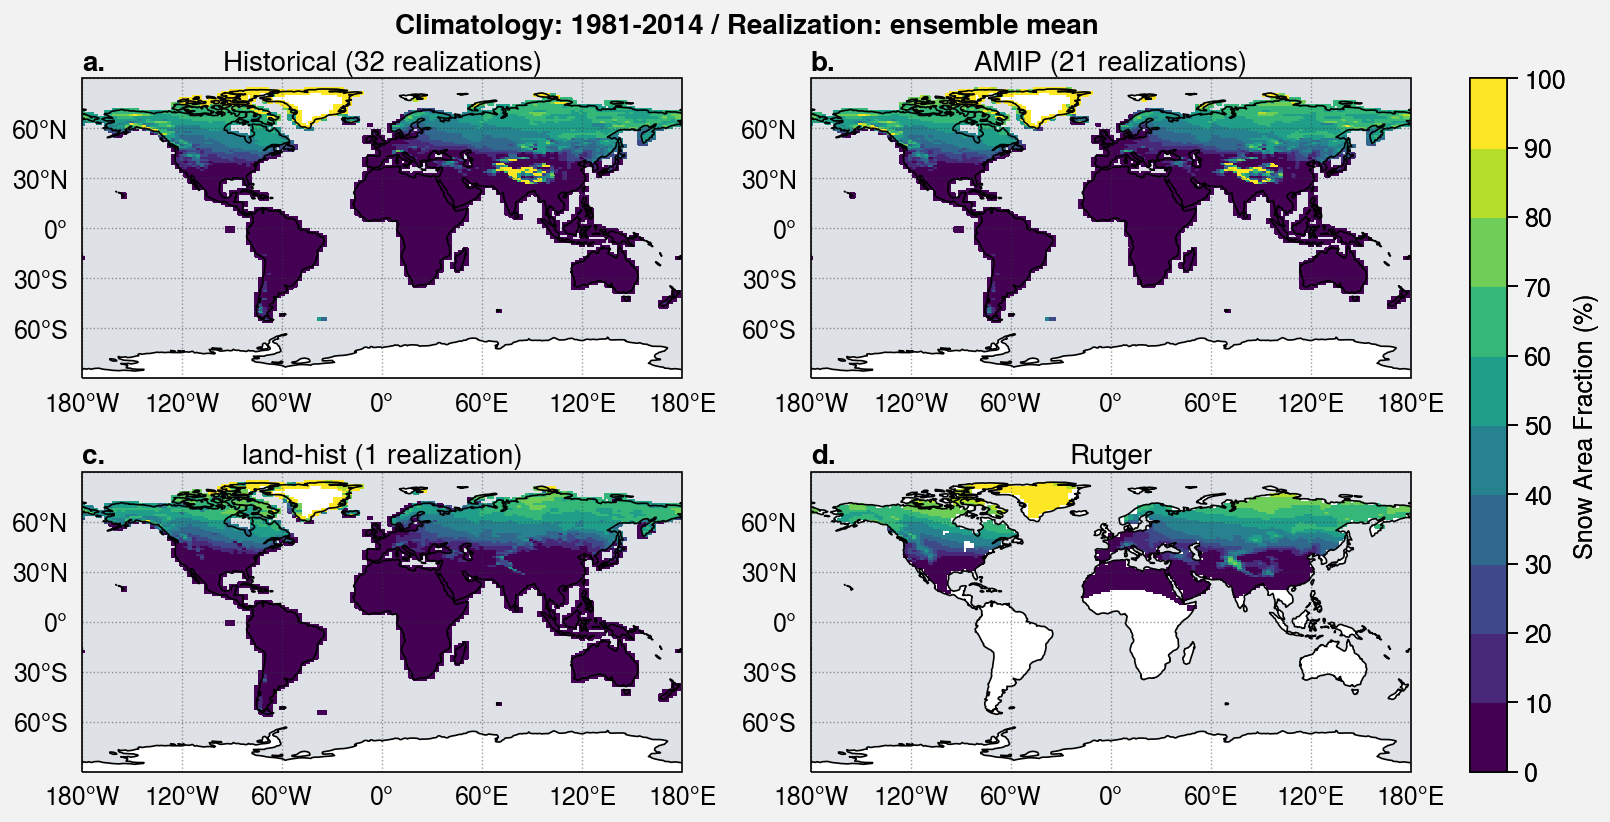

In [14]:
# First guess plot comparison
f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

cmap='viridis'
levels=plot.arange(0,100,10)

m = axs[0].pcolormesh(snc_historical_clim, cmap=cmap, levels=levels)
axs[0].format(title='Historical ('+str(snc_historical.realization.size)+' realizations)')
axs[1].pcolormesh(snc_amip_clim, cmap=cmap, levels=levels)
axs[1].format(title='AMIP ('+str(snc_amip.realization.size)+' realizations)')
axs[2].pcolormesh(snc_land_hist_clim, cmap=cmap, levels=levels)
axs[2].format(title='land-hist ('+str(snc_land_hist.realization.size)+' realization)')
axs[3].pcolormesh(snc_rutger_regrid_clim, cmap=cmap, levels=levels)
axs[3].format(title='Rutger')

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3',
    suptitle="Climatology: 1981-2014 / Realization: ensemble mean",
    lonlines=60, latlines=30, abc=True, abcstyle='a.'
)

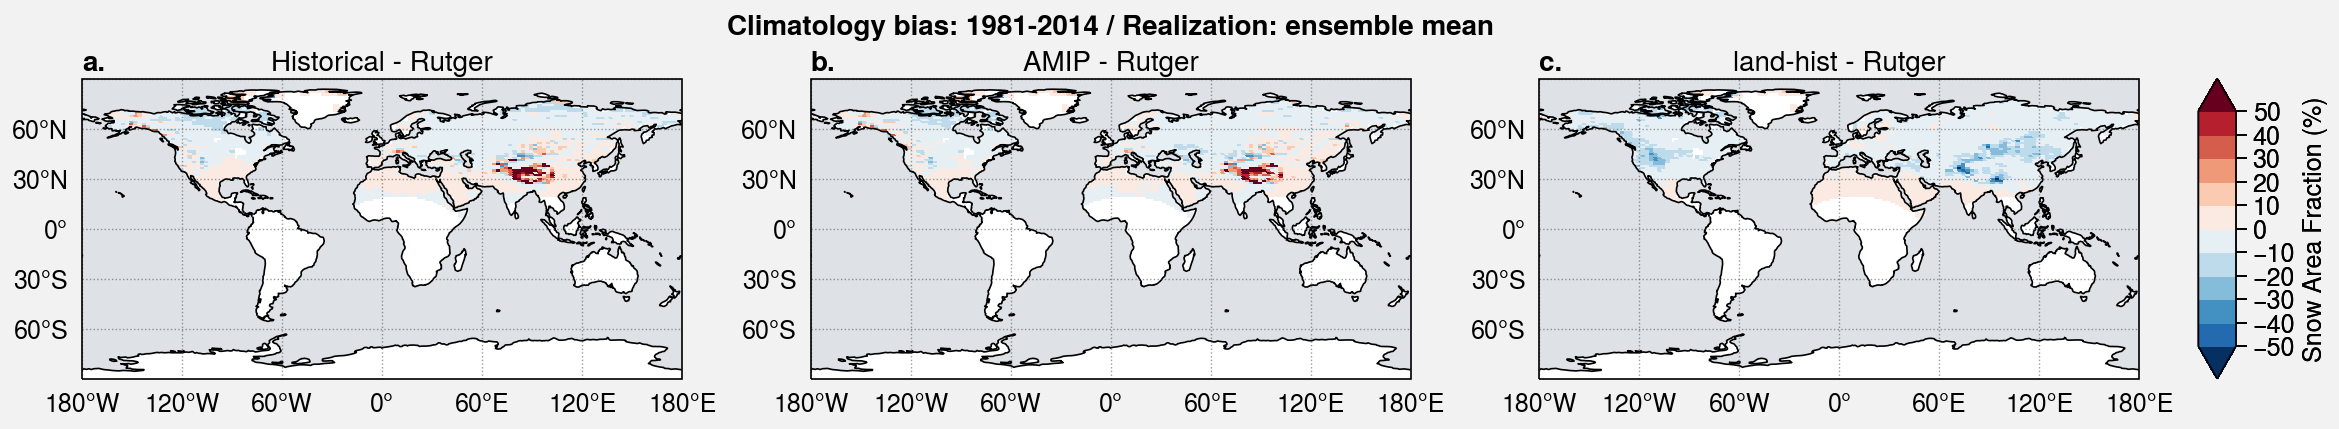

In [15]:
# Differences from Rutger
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1, share=3, axwidth=3)

cmap='RdBu_r'
levels=plot.arange(-50,50,10)

m = axs[0].pcolormesh(snc_historical_clim-snc_rutger_regrid_clim, cmap=cmap, levels=levels, extend='both')
axs[0].format(title='Historical - Rutger')
axs[1].pcolormesh(snc_amip_clim-snc_rutger_regrid_clim, cmap=cmap, levels=levels, extend='both')
axs[1].format(title='AMIP - Rutger')
axs[2].pcolormesh(snc_land_hist_clim-snc_rutger_regrid_clim, cmap=cmap, levels=levels, extend='both')
axs[2].format(title='land-hist - Rutger')

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3',
    suptitle="Climatology bias: 1981-2014 / Realization: ensemble mean",
    lonlines=60, latlines=30, abc=True, abcstyle='a.'
)

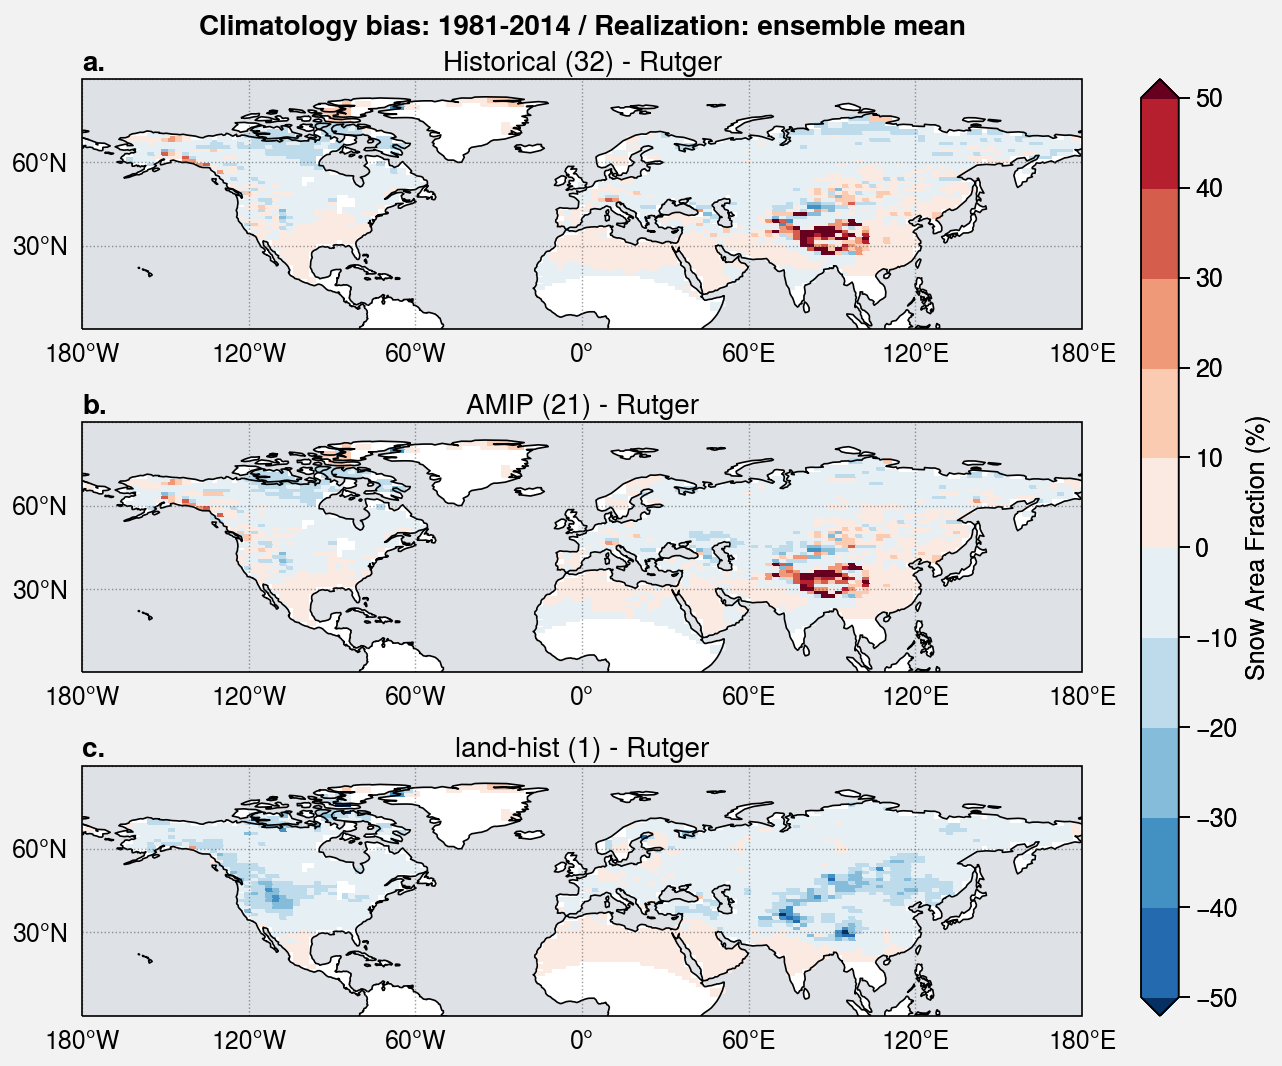

In [22]:
# Differences from Rutger
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=3, share=3, axwidth=5)

cmap='RdBu_r'
levels=plot.arange(-50,50,10)

m = axs[0].pcolormesh(snc_historical_clim-snc_rutger_regrid_clim, cmap=cmap, levels=levels, extend='both')
axs[0].format(title='Historical ('+str(snc_historical.realization.size)+') - Rutger')
axs[1].pcolormesh(snc_amip_clim-snc_rutger_regrid_clim, cmap=cmap, levels=levels, extend='both')
axs[1].format(title='AMIP ('+str(snc_amip.realization.size)+') - Rutger')
axs[2].pcolormesh(snc_land_hist_clim-snc_rutger_regrid_clim, cmap=cmap, levels=levels, extend='both')
axs[2].format(title='land-hist ('+str(snc_land_hist.realization.size)+') - Rutger')

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3',
    suptitle="Climatology bias: 1981-2014 / Realization: ensemble mean",
    lonlines=60, latlines=30, abc=True, abcstyle='a.', latlim=(0,90)
)

f.save('bias_hist_amip_land.png')